# Análise dos dados de fixação ocular nas Áres de Interesse (AOI)

- Considerações iniciais:
    - O conjunto de dados possui 9.6 GB e requer abordagem para grande volume de dados (BIG DATA)
    - Os dados foram exportados do software Tobii Studio em um arquivo para cada voluntário
    - O conjunto de dados possui 142 voluntários
    - Cada voluntário visualizou 20 estímulos faciais 
    - Cada estímulo possui 14 AOIs 
    
- Obetivos:
    - Determinar:
        - Coordenadas do ponto zero (primeira fixação)
        - AOI da primeira fixação (considerada a primeira fixação de busca após ponto zero)
        - Tempo da pupila máxima
        - Diâmetro da pupila máxima
        - AOI da pupila máxima
        - Número de fixações entre a primeira fixação e a fixação da pupila máxima
        - Tempo entre a primeira fixação e a pupila máxima
        - Número de fixações entre a fixação em cada uma das AOIs e a fixação da pupila máxima
        - Tempo entre a fixação em cada uma das AOIs e a pupila máxima
        - AOI da penúltima fixação (antes da pupila máxima)
        - Tempo da penúltima fixação (antes da pupila máxima)
        - AOI da ante-penúltima fixação (antes da pupila máxima)
        - Tempo da ante-penúltima fixação (antes da pupila máxima)
        - AOI da ante-ante-penúltima fixação (antes da pupila máxima)
        - Tempo da ante-ante-penúltima fixação (antes da pupila máxima)
        

##### Passo 1: Exportar os dados do Tobii 

- Selecione as gravações do conjuntos de dados (se não souber quais selecionar, pode selecionar todas)
- Selecione as variáveis do conjuntos de dados (se não souber quais selecionar, pode selecionar todas)
- **Importante:** Selecione a opção "Individual Files" na saída dos dados. Ao selecionar essa opção será gerado um arquivo para cada gravação, o que facilita o processamento dos dados em relação ao tamanho total do conjunto de dados em um único arquivo. 

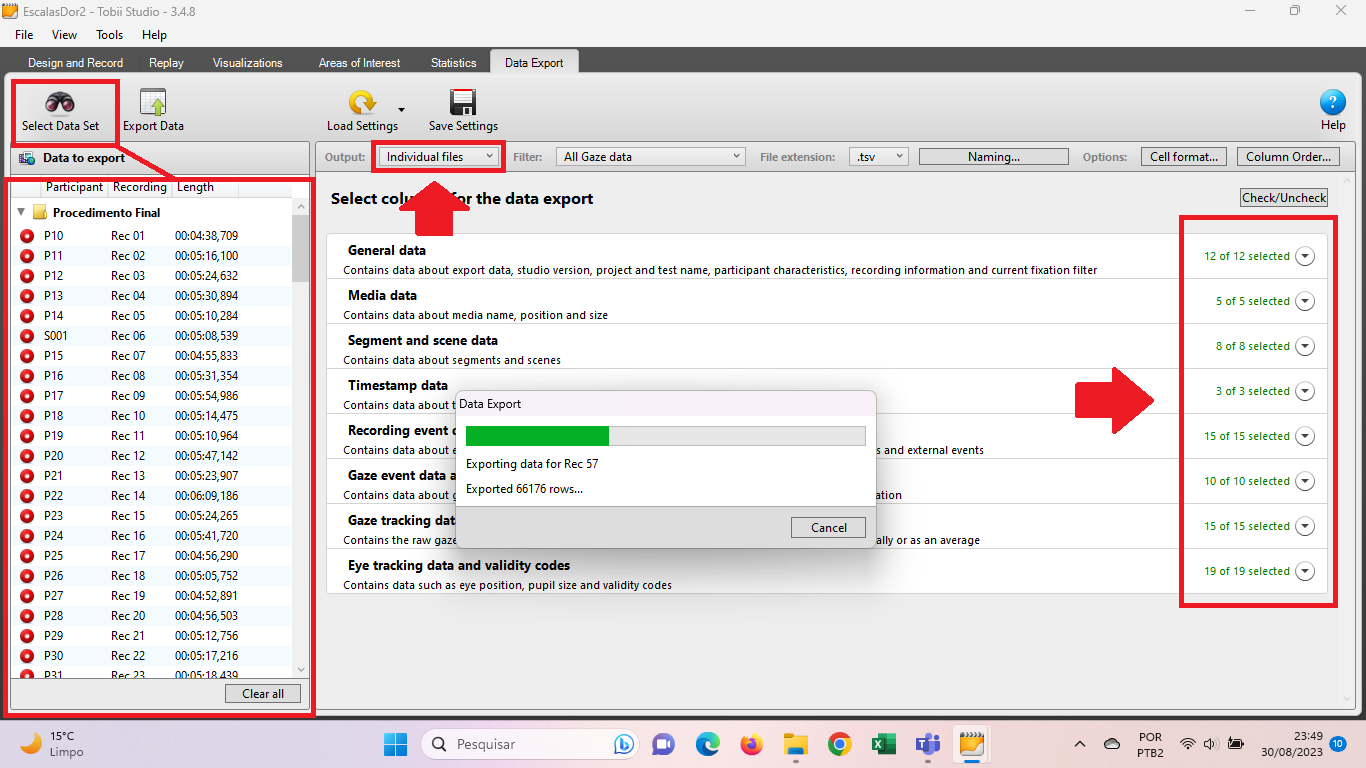

Considerando o tamanho deste conjunto de dados, esta operação pode levar de 2 a 4 horas.

##### Passo 2: Importa as bibliotecas necessárais

In [1]:
import re
import glob
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt

##### Passo 3: Importar os dados para o Pyhton e filtrar as áreas de interesse

In [2]:
# Registra o horário de início do processamento 
timestamp_start = datetime.datetime.now().timestamp()

In [3]:
# Função para filtrar as áreas de interesse

# Configura um padrão de busca para localizar as colunas das AOI
regex = r"\[(.*?)\]"

# Define os parâmetros de entrada da função
def AOIFilter(files, aoi_full=None): 

    # Cria uma variável para armazerar o conjunto de dados
    dataset = pd.DataFrame()
    # Laço de repetição para listar todos os arquivos do diretório
    for file in files:
        # Lê cada arquivo e filtra as colunas que serão analisadas 
        raw_data = pd.read_csv(file, sep="\t", low_memory=False)#[variaveis]
        # Filtra todas as colunas com o padrão declarado na variável regex
        aoi_cols = raw_data.filter(regex=r'AOI.*').columns
        
        # Declara variável para receber a lista de nomes das AOI
        aoi_names = []
        # Laço de repetição para ler o nome de todas as colunas filtradas
        for c in aoi_cols:
            # Busca o padrão declarado na função regex
            match = re.search(regex, c)
            # Se encontrar o padrão regex, adiciona a string na lista de nomes de AOI
            if match:
                aoi_names.append(match.group(1))
    
        # Filtra todos os nomes repetidos para obter uma lista de elementos distintos
        aoi_names = set(aoi_names)
        # Cria uma cópia do arquivo lido excluindo as colunas filtradas com o padrão regex
        data = raw_data.copy().drop(aoi_cols,axis=1)
        # Cria uma lista auxiliar vazia, com a mesma dimensão do do arquivo lido
        aux = pd.Series(np.nan, index = np.arange(len(raw_data)))
        
        # Laço de repetição para ler o nome de todas as AOIs
        for an in aoi_names:
            # Filtra todas as AOIs com o mesmo nome
            aoi = raw_data.filter(regex=rf'AOI\[{an}\].*')
            # Faz o empilhamento das AOIs com o mesmo nome em uma nova coluna, excluindo as colunas originais
            data[an] = aoi.stack().reset_index(level=1,drop=True)
        
        # Laço de repetição para ler o nome de todas as AOIs
        for an in aoi_names:
            # Se o nome da varíavel for diferente do variável aoi_full, definida na entrada, então:
            if an != aoi_full:
                # A variável aux recebe o nome da AOI nas posições da matrix com valor igual a 1
                aux[data[an][data[an]==1].index]=an
        # Cria uma nova coluna com os dados da variável aux        
        data['AOI'] = aux
        
        # Se a função receber o parâmetro aoi_full, então:
        if aoi_full:
            # Substitui os valores vazios da coluna AOI por NA
            data.loc[data[aoi_full] == 1, 'AOI'] = data.loc[data[aoi_full] == 1, 'AOI'].fillna(aoi_full)     
    
        # Adiciona os dados filtrados ao conjunto de dados total
        dataset = pd.concat([dataset,data])
    
    # Seleciona as colunas/variáveis do conjunto de dados que serão utilziados na análise
    variaveis = ['RecordingName',
                 'MediaName',
                 'LocalTimeStamp',
                 'PupilRight',
                 'FixationIndex',
                 'FixationPointX (MCSpx)',
                 'FixationPointY (MCSpx)',
                 'AOI']

    # Filtra as colunas/variaiveis selecionadas
    dataset = dataset[variaveis]
    
    # Renomeia as colunas para facilitar a visualização da tabela
    dataset.rename(columns = {'RecordingName':'Rec',
                              'LocalTimeStamp': 'Time',
                              'PupilRight':'Pupil',
                              'FixationIndex':'FI',
                              'FixationPointX (MCSpx)':'X',
                              'FixationPointY (MCSpx)':'Y'}, inplace = True)

    # Remove as linhas sem AOI registrada 
    dataset = dataset[dataset.AOI.notna()]
        
    return dataset   

##### Passo 4: Selecionar as gravações para análise

In [4]:
# Seleciona as gravações válidos

# medicos = 44
medicos = ['Rec 07', 'Rec 18', 'Rec 19', 'Rec 20', 'Rec 22', 'Rec 23', 'Rec 25', 'Rec 28', 'Rec 30', 'Rec 38',
           'Rec 40', 'Rec 39', 'Rec 58', 'Rec 67', 'Rec 75', 'Rec 76', 'Rec 77', 'Rec 81', 'Rec 82', 'Rec 85',
           'Rec 86', 'Rec 91', 'Rec 92', 'Rec 95', 'Rec 115', 'Rec 116', 'Rec 125', 'Rec 126', 'Rec 133', 'Rec 134',
           'Rec 135', 'Rec 138', 'Rec 140', 'Rec 141', 'Rec 143', 'Rec 144', 'Rec 145', 'Rec 149', 'Rec 152', 'Rec 154',
           'Rec 155', 'Rec 156', 'Rec 157', 'Rec 158']

# op (outros profissionais) = 40
op = ['Rec 09', 'Rec 11', 'Rec 13', 'Rec 14', 'Rec 15', 'Rec 21', 'Rec 24', 'Rec 31', 'Rec 46', 'Rec 47',
      'Rec 55', 'Rec 61', 'Rec 63', 'Rec 65', 'Rec 66', 'Rec 72', 'Rec 74', 'Rec 83', 'Rec 84', 'Rec 87',
      'Rec 88', 'Rec 89', 'Rec 90', 'Rec 102', 'Rec 104', 'Rec 107', 'Rec 119', 'Rec 120', 'Rec 121', 'Rec 122',
      'Rec 123', 'Rec 124', 'Rec 127', 'Rec 128', 'Rec 129', 'Rec 130', 'Rec 131', 'Rec 136', 'Rec 137', 'Rec 139']

# pais = 29.
pais = ['Rec 12', 'Rec 27', 'Rec 26', 'Rec 32', 'Rec 33', 'Rec 34', 'Rec 41', 'Rec 43', 'Rec 44', 'Rec 45',
        'Rec 68', 'Rec 69', 'Rec 73', 'Rec 78', 'Rec 79', 'Rec 94', 'Rec 96', 'Rec 99', 'Rec 106', 'Rec 109',
        'Rec 112', 'Rec 113', 'Rec 114', 'Rec 117', 'Rec 118', 'Rec 146', 'Rec 147', 'Rec 150', 'Rec 151']

# leigos = 29.
leigos = ['Rec 08', 'Rec 29', 'Rec 35', 'Rec 36', 'Rec 37', 'Rec 42', 'Rec 48', 'Rec 49', 'Rec 50', 'Rec 51',
          'Rec 52', 'Rec 53', 'Rec 56', 'Rec 57', 'Rec 59', 'Rec 60', 'Rec 62', 'Rec 70', 'Rec 71', 'Rec 80',
          'Rec 93', 'Rec 97', 'Rec 98', 'Rec 100', 'Rec 105', 'Rec 108', 'Rec 110', 'Rec 111', 'Rec 153']

# Lista completa com todas as gravações
Rec = medicos + op + pais + leigos

# Laço de repetição para para acrescentar a extensão do arquivo .tsv
for i in range(len(medicos)):
    medicos[i] += '.tsv'
for i in range(len(op)):
    op[i] += '.tsv'
for i in range(len(pais)):
    pais[i] += '.tsv'
for i in range(len(leigos)):
    leigos[i] += '.tsv'

##### Passo 5: Filtrar as áreas de interesse (AOI)

In [5]:
# Filtra as áreas de interesse (AOI) por classe
# Devido ao tamanho do conjunto de dados, não é possível armazenar tudo em uma única variável
data_medicos = AOIFilter(medicos, 'Face')
data_op = AOIFilter(op, 'Face')
data_pais = AOIFilter(pais, 'Face')
data_leigos = AOIFilter(leigos, 'Face')

In [6]:
# Nesta etapa, após filtrar os conjuntos de dados, é feita a concatenação de todas as classes em uma única variável
dataset = pd.concat([data_medicos,data_op,data_pais,data_leigos])

# Remove as linhas sem AOI registrada 
dataset = dataset[dataset.AOI.notna()]

# Filtra somente os participantes válidos 
dataset = dataset[dataset.Rec.isin(Rec)]

# Imprime uma amostra com os 10 primeiros valores da tabela
dataset.head(10)

,Rec,MediaName,Time,Pupil,FI,X,Y,AOI
15129,Rec 07,19_114922.bmp,15:32:02.509,"3,26",185.0,340.0,258.0,Nariz
15130,Rec 07,19_114922.bmp,15:32:02.513,"3,22",185.0,340.0,258.0,Nariz
15131,Rec 07,19_114922.bmp,15:32:02.516,"3,21",185.0,340.0,258.0,Nariz
15132,Rec 07,19_114922.bmp,15:32:02.519,"3,20",185.0,340.0,258.0,Nariz
15133,Rec 07,19_114922.bmp,15:32:02.523,"3,28",185.0,340.0,258.0,Nariz
15134,Rec 07,19_114922.bmp,15:32:02.526,"3,29",185.0,340.0,258.0,Nariz
15135,Rec 07,19_114922.bmp,15:32:02.529,"3,32",185.0,340.0,258.0,Nariz
15136,Rec 07,19_114922.bmp,15:32:02.533,"3,28",185.0,340.0,258.0,Nariz
15137,Rec 07,19_114922.bmp,15:32:02.536,"3,28",185.0,340.0,258.0,Nariz
15138,Rec 07,19_114922.bmp,15:32:02.539,"3,18",185.0,340.0,258.0,Nariz


##### Passo 6: Filtrar os estímulos para análise

In [7]:
# Seleciona os estímulos válidos 
com_dor = ["05_105754_110248.bmp","06_112553.bmp","07_114907.bmp","08_150212.bmp","09_142318_142459.bmp",
           "15_151810.bmp","19_114922.bmp","20_122527.bmp","24_150657_150701.bmp","25_103203.bmp"] 
sem_dor = ["05_110222.bmp","06_112348_145026.bmp","07_114829.bmp", "08_150034_150434.bmp","09_141714.bmp",
           "15_151515.bmp","19_114838.bmp","20_122223.bmp","24_150608.bmp","25_103048.bmp"]

# Lista completa com todas as imagens
stimuli = com_dor + sem_dor

# Filtra somente os estímulos válidos 
dataset = dataset[dataset.MediaName.isin(stimuli)] 

# Imprime uma amostra com os 10 primeiros valores da tabela
dataset.head(10)

,Rec,MediaName,Time,Pupil,FI,X,Y,AOI
15129,Rec 07,19_114922.bmp,15:32:02.509,"3,26",185.0,340.0,258.0,Nariz
15130,Rec 07,19_114922.bmp,15:32:02.513,"3,22",185.0,340.0,258.0,Nariz
15131,Rec 07,19_114922.bmp,15:32:02.516,"3,21",185.0,340.0,258.0,Nariz
15132,Rec 07,19_114922.bmp,15:32:02.519,"3,20",185.0,340.0,258.0,Nariz
15133,Rec 07,19_114922.bmp,15:32:02.523,"3,28",185.0,340.0,258.0,Nariz
15134,Rec 07,19_114922.bmp,15:32:02.526,"3,29",185.0,340.0,258.0,Nariz
15135,Rec 07,19_114922.bmp,15:32:02.529,"3,32",185.0,340.0,258.0,Nariz
15136,Rec 07,19_114922.bmp,15:32:02.533,"3,28",185.0,340.0,258.0,Nariz
15137,Rec 07,19_114922.bmp,15:32:02.536,"3,28",185.0,340.0,258.0,Nariz
15138,Rec 07,19_114922.bmp,15:32:02.539,"3,18",185.0,340.0,258.0,Nariz


##### Passo 7: Corrigir tipo e formato de dados

In [8]:
# Substitui a vírgula por ponto. Usa o parâmetro regex para aplicar ao df
dataset["Pupil"] = dataset["Pupil"].replace(",",".", regex=True)

# Converte o tipo de dados em numérico (Float)
dataset["Pupil"] = pd.to_numeric(dataset["Pupil"])

# Imprime uma amostra com os 10 primeiros valores da tabela
dataset.head(10)

,Rec,MediaName,Time,Pupil,FI,X,Y,AOI
15129,Rec 07,19_114922.bmp,15:32:02.509,3.26,185.0,340.0,258.0,Nariz
15130,Rec 07,19_114922.bmp,15:32:02.513,3.22,185.0,340.0,258.0,Nariz
15131,Rec 07,19_114922.bmp,15:32:02.516,3.21,185.0,340.0,258.0,Nariz
15132,Rec 07,19_114922.bmp,15:32:02.519,3.20,185.0,340.0,258.0,Nariz
15133,Rec 07,19_114922.bmp,15:32:02.523,3.28,185.0,340.0,258.0,Nariz
15134,Rec 07,19_114922.bmp,15:32:02.526,3.29,185.0,340.0,258.0,Nariz
15135,Rec 07,19_114922.bmp,15:32:02.529,3.32,185.0,340.0,258.0,Nariz
15136,Rec 07,19_114922.bmp,15:32:02.533,3.28,185.0,340.0,258.0,Nariz
15137,Rec 07,19_114922.bmp,15:32:02.536,3.28,185.0,340.0,258.0,Nariz
15138,Rec 07,19_114922.bmp,15:32:02.539,3.18,185.0,340.0,258.0,Nariz


##### Passo 8: Análise das AOIs

In [74]:
#Cria um DataFrame para armazenar os dados
dados = pd.DataFrame()

# Cria listas para armazenar erros
erro_rec = []
erro_estimulo = []

N = 0
for i in Rec:
    for j in stimuli:
        # Filtra a participante e o estímulo
        dftemp = dataset.loc[(dataset['Rec']==i)&(dataset['MediaName']==j)]
        
        # Remove os indices de fixações duplicados e mantém a ordem do sinal
        dftemp_ID_sort = dftemp.drop_duplicates('FI')
        
        # Ordena o tamanho da pupila pelo indice de cada fixação e remove os indices de fixações duplicadas
        #dftemp_ID_pupila_max = dftemp.sort_values(by=['FI', 'Pupil'], ascending=[True, False]).drop_duplicates('FI')
        
        # Identifica o participante filtrado
        dados.at[N,'Rec'] = i

        # Identifica o estímulo filtrado
        dados.at[N,'Estímulo'] = j
        
        # Coordenada do ponto zero (primeira fixação)
        try:
            dados.at[N,'X_Inicial'] = dftemp.X.iloc[0]
            dados.at[N,'Y_Inicial'] = dftemp.Y.iloc[0]

            # AOI da coodenada do ponto zero
            dados.at[N,'AOI_Inicial'] = dftemp_ID_sort.AOI.iloc[0]
            
            # AOI da primeira fixação (considerada a primeira fixação de busca após ponto zero)
            try:
                dados.at[N,'AOI_Primeira_Fixação'] = dftemp_ID_sort.AOI.iloc[1]
            except:
                dados.at[N,'AOI_Primeira_Fixação'] = pd.NA

            # ======================================== PUPILA MÁXIMA ========================================
            # Filtra Pico da Pupila
            pico = dftemp.loc[dftemp['Pupil']==dftemp['Pupil'].max()]
            # Filtra o primeiro pico caso tenha mais de um pico com o mesmo valor
            pico = pico.sort_values(by='FI', ascending=True).drop_duplicates('Pupil')
            # Filtra o dataframe anterior ao pico
            dfpico = dftemp.loc[dftemp['FI']<=pico.FI.iloc[0]].drop_duplicates('FI')
            # Filtra o dataframe anterior ao pico removendo os indices duplicados
            #dfpico_ID = dftemp.loc[dftemp['FI']<=pico.FI.iloc[0]].drop_duplicates('FI')
            
            # Tempo da pupila máxima
            # Subtrai o momento da pupila máxima (registrado no relógio do computador) do momento da primeira fixação
            dados.at[N,'Tempo_Pupila_Máxima'] = max(0,int((pd.Timedelta(pico.Time.iloc[0])-
                                                     pd.Timedelta(dftemp_ID_sort.Time.iloc[0])).total_seconds()*1000))
            
            # Diâmetro da pupila máxima
            dados.at[N,'Diâmetro_Pupila_Máxima'] = pico.Pupil.iloc[0]
            
            #AOI da pupila máxima
            dados.at[N,'AOI_Pupila_Máxima'] = pico.AOI.iloc[0]
            
            # Número de fixações entre a primeira fixação e a fixação da pupila máxima
            dados.at[N,'NumFix1a_PupilMax'] = len(dfpico)-1 #pico.FI.iloc[0]-dftemp_ID_sort.FI.iloc[0]
            
            # Tempo entre a primeira fixação e a pupila máxima
            dados.at[N,'TempoFix1a_PupilMax'] = max(0,int((pd.Timedelta(pico.Time.iloc[0])-
                                                     pd.Timedelta(dftemp_ID_sort.Time.iloc[1])).total_seconds()*1000))
            
            # =========================================== QUEIXO ============================================
            if (dfpico['AOI'] == 'Queixo').any():
                # Filtra Queixo
                queixo = dfpico.loc[dfpico['AOI']=='Queixo']
                dfqueixo = dfpico.loc[dfpico['FI']>=queixo.FI.iloc[0]]
                # Número de fixações entre a fixação na QUEIXO e a fixação da pupila máxima
                dados.at[N,'NumFixQueixo_PupilMax'] = len(dfqueixo) #pico.FI.iloc[0]-dfqueixo.FI.iloc[0]
                # Tempo entre a fixação na QUEIXO e a pupila máxima
                dados.at[N,'TempoFixQueixo_PupilMax'] = max(0,int((pd.Timedelta(pico.Time.iloc[0])-
                                                             pd.Timedelta(dfqueixo.Time.iloc[0])).total_seconds()*1000))
            else:
                dados.at[N,'NumFixQueixo_PupilMax'] = pd.NA
                dados.at[N,'TempoFixQueixo_PupilMax'] = pd.NA

            # ========================================= BOCHECHA D ============================================
            if (dfpico['AOI'] == 'Bochecha D').any():
                # Filtra Bocheca D
                bochecad = dfpico.loc[dfpico['AOI']=='Bochecha D']               
                dfbochecad = dfpico.loc[dfpico['FI']>=bochecad.FI.iloc[0]]
                # Número de fixações entre a fixação na BOCHECHA D e a fixação da pupila máxima
                dados.at[N,'NumFixBochechaD_PupilMax'] = len(dfbochecad) #pico.FI.iloc[0]-dfbochecad.FI.iloc[0]
                # Tempo entre a fixação na BOCHECHA D e a pupila máxima
                dados.at[N,'TempoFixBochechaD_PupilMax'] = max(0,int((pd.Timedelta(pico.Time.iloc[0])-
                                                                pd.Timedelta(dfbochecad.Time.iloc[0])).total_seconds()*1000))
            else:
                dados.at[N,'NumFixBochechaD_PupilMax'] = pd.NA
                dados.at[N,'TempoFixBochechaD_PupilMax'] = pd.NA

            # ========================================= BOCHECHA E ============================================
            if (dfpico['AOI'] == 'Bochecha E').any():
                # Filtra Bocheca E
                bochecae = dfpico.loc[dfpico['AOI']=='Bochecha E']               
                dfbochecae = dfpico.loc[dfpico['FI']>=bochecae.FI.iloc[0]]
                # Número de fixações entre a fixação na BOCHECHA E e a fixação da pupila máxima
                dados.at[N,'NumFixBochechaE_PupilMax'] = len(dfbochecae) #pico.FI.iloc[0]-dfbochecae.FI.iloc[0]
                # Tempo entre a fixação na BOCHECHA D e a pupila máxima
                dados.at[N,'TempoFixBochechaE_PupilMax'] = max(0,int((pd.Timedelta(pico.Time.iloc[0])-
                                                                pd.Timedelta(dfbochecae.Time.iloc[0])).total_seconds()*1000))
            else:
                dados.at[N,'NumFixBochechaE_PupilMax'] = pd.NA
                dados.at[N,'TempoFixBochechaE_PupilMax'] = pd.NA

            # ============================================= BOCA ============================================
            if (dfpico['AOI'] == 'Boca').any():
                # Filtra Boca
                boca = dfpico.loc[dfpico['AOI']=='Boca']
                dfboca = dfpico.loc[dfpico['FI']>=boca.FI.iloc[0]]
                # Número de fixações entre a fixação na BOCA e a fixação da pupila máxima
                dados.at[N,'NumFixBoca_PupilMax'] = len(dfboca) #pico.FI.iloc[0]-dfboca.FI.iloc[0]
                # Tempo entre a fixação na BOCA e a pupila máxima
                dados.at[N,'TempoFixBoca_PupilMax'] = max(0,int((pd.Timedelta(pico.Time.iloc[0])-
                                                           pd.Timedelta(dfboca.Time.iloc[0])).total_seconds()*1000))
            else:
                dados.at[N,'NumFixBoca_PupilMax'] = pd.NA
                dados.at[N,'TempoFixBoca_PupilMax'] = pd.NA

            # ============================================ SNL D ============================================
            if (dfpico['AOI'] == 'Sulco Nasolabial D.').any():
                # Filtra SNLD
                snld = dfpico.loc[dfpico['AOI']=='Sulco Nasolabial D.']               
                dfsnld = dfpico.loc[dfpico['FI']>=snld.FI.iloc[0]]
                # Número de fixações entre a fixação na SNLD e a fixação da pupila máxima
                dados.at[N,'NumFixSNLD_PupilMax'] = len(dfsnld) #pico.FI.iloc[0]-dfsnld.FI.iloc[0]
                # Tempo entre a fixação na SNLD e a pupila máxima
                dados.at[N,'TempoFixSNLD_PupilMax'] = max(0,int((pd.Timedelta(pico.Time.iloc[0])-
                                                           pd.Timedelta(dfsnld.Time.iloc[0])).total_seconds()*1000))
            else:
                dados.at[N,'NumFixSNLD_PupilMax'] = pd.NA
                dados.at[N,'TempoFixSNLD_PupilMax'] = pd.NA

            # ============================================ SNL E =============================================
            if (dfpico['AOI'] == 'Sulco Nasolabial E.').any():
                # Filtra SNLE
                snle = dfpico.loc[dfpico['AOI']=='Sulco Nasolabial E.']               
                dfsnle = dfpico.loc[dfpico['FI']>=snle.FI.iloc[0]]
                # Número de fixações entre a fixação na SNLE e a fixação da pupila máxima
                dados.at[N,'NumFixSNLE_PupilMax'] = len(dfsnle) #pico.FI.iloc[0]-dfsnle.FI.iloc[0]
                # Tempo entre a fixação na SNLE e a pupila máxima
                dados.at[N,'TempoFixSNLE_PupilMax'] = max(0,int((pd.Timedelta(pico.Time.iloc[0])-
                                                           pd.Timedelta(dfsnle.Time.iloc[0])).total_seconds()*1000))
            else:
                dados.at[N,'NumFixSNLE_PupilMax'] = pd.NA
                dados.at[N,'TempoFixSNLE_PupilMax'] = pd.NA

            # ============================================ NARIZ ============================================
            if (dfpico['AOI'] == 'Nariz').any():
                # Filtra Nariz
                nariz = dfpico.loc[dfpico['AOI']=='Nariz']
                dfnariz = dfpico.loc[dfpico['FI']>=nariz.FI.iloc[0]]
                # Número de fixações entre a fixação na NARIZ e a fixação da pupila máxima
                dados.at[N,'NumFixNariz_PupilMax'] = len(dfnariz) #pico.FI.iloc[0]-dfnariz.FI.iloc[0]
                # Tempo entre a fixação na NARIZ e a pupila máxima
                dados.at[N,'TempoFixNariz_PupilMax'] = max(0,int((pd.Timedelta(pico.Time.iloc[0])-
                                                            pd.Timedelta(dfnariz.Time.iloc[0])).total_seconds()*1000))
            else:
                dados.at[N,'NumFixNariz_PupilMax'] = pd.NA
                dados.at[N,'TempoFixNariz_PupilMax'] = pd.NA 

            # ============================================ OLHO D ============================================
            if (dfpico['AOI'] == 'Olho D').any():
                # Filtra Olho D
                olhod = dfpico.loc[dfpico['AOI']=='Olho D']
                dfolhod = dfpico.loc[dfpico['FI']>=olhod.FI.iloc[0]]
                # Número de fixações entre a fixação na OLHO D e a fixação da pupila máxima
                dados.at[N,'NumFixOlhoD_PupilMax'] = len(dfolhod) #pico.FI.iloc[0]-dfolhod.FI.iloc[0]
                # Tempo entre a fixação na OLHO D e a pupila máxima
                dados.at[N,'TempoFixOlhoD_PupilMax'] = max(0,int((pd.Timedelta(pico.Time.iloc[0])-
                                                            pd.Timedelta(dfolhod.Time.iloc[0])).total_seconds()*1000))
            else:
                dados.at[N,'NumFixOlhoD_PupilMax'] = pd.NA
                dados.at[N,'TempoFixOlhoD_PupilMax'] = pd.NA

            # ============================================ OLHO E ============================================
            if (dfpico['AOI'] == 'Olho E').any():
                # Filtra Olho E
                olhoe = dfpico.loc[dfpico['AOI']=='Olho E']
                dfolhoe = dfpico.loc[dfpico['FI']>=olhoe.FI.iloc[0]]
                # Número de fixações entre a fixação na OLHO E e a fixação da pupila máxima
                dados.at[N,'NumFixOlhoE_PupilMax'] = len(dfolhoe) #pico.FI.iloc[0]-dfolhoe.FI.iloc[0]
                # Tempo entre a fixação na OLHO E e a pupila máxima
                dados.at[N,'TempoFixOlhoE_PupilMax'] = max(0,int((pd.Timedelta(pico.Time.iloc[0])-
                                                            pd.Timedelta(dfolhoe.Time.iloc[0])).total_seconds()*1000))
            else:
                dados.at[N,'NumFixOlhoE_PupilMax'] = pd.NA
                dados.at[N,'TempoFixOlhoE_PupilMax'] = pd.NA 

            # ========================================= SOBRANCELHA D ========================================
            if (dfpico['AOI'] == 'Sobrancelha D').any():
                # Filtra Sobrancelha D
                sobrancelhad = dfpico.loc[dfpico['AOI']=='Sobrancelha D']
                dfsobrancelhad = dfpico.loc[dfpico['FI']>=sobrancelhad.FI.iloc[0]]
                # Número de fixações entre a fixação na SOBRANCELHA D e a fixação da pupila máxima
                dados.at[N,'NumFixSobrancelhaD_PupilMax'] = len(dfsobrancelhad) #pico.FI.iloc[0]-dfsobrancelhad.FI.iloc[0]
                # Tempo entre a fixação na SOBRANCELHA D e a pupila máxima
                dados.at[N,'TempoFixSobrancelhaD_PupilMax'] = max(0,int((pd.Timedelta(pico.Time.iloc[0])-
                                                                   pd.Timedelta(dfsobrancelhad.Time.iloc[0])).total_seconds()*1000))
            else:
                dados.at[N,'NumFixSobrancelhaD_PupilMax'] = pd.NA
                dados.at[N,'TempoFixSobrancelhaD_PupilMax'] = pd.NA

            # ========================================= SOBRANCELHA E ========================================
            if (dfpico['AOI'] == 'Sobrancelha E').any():
                # Filtra Sobrancelha E
                sobrancelhae = dfpico.loc[dfpico['AOI']=='Sobrancelha E']
                dfsobrancelhae = dfpico.loc[dfpico['FI']>=sobrancelhae.FI.iloc[0]]
                # Número de fixações entre a fixação na SOBRANCELHA E e a fixação da pupila máxima
                dados.at[N,'NumFixSobrancelhaE_PupilMax'] = len(dfsobrancelhae) #pico.FI.iloc[0]-dfsobrancelhae.FI.iloc[0]
                # Tempo entre a fixação na SOBRANCELHA E e a pupila máxima
                dados.at[N,'TempoFixSobrancelhaE_PupilMax'] = max(0,int((pd.Timedelta(pico.Time.iloc[0])-
                                                                   pd.Timedelta(dfsobrancelhae.Time.iloc[0])).total_seconds()*1000))
            else:
                dados.at[N,'NumFixSobrancelhaE_PupilMax'] = pd.NA
                dados.at[N,'TempoFixSobrancelhaE_PupilMax'] = pd.NA

            # ==================================== ENTRE SOBRANCELHAS =======================================
            if (dfpico['AOI'] == 'Entre Sobrancelhas').any():
                # Filtra Entre Sobrancelhas
                entres = dfpico.loc[dfpico['AOI']=='Entre Sobrancelhas']
                dfentres = dfpico.loc[dfpico['FI']>=entres.FI.iloc[0]]
                # Número de fixações entre a fixação na ENTRE SOBRANCELHAS E e a fixação da pupila máxima
                dados.at[N,'NumFixESobrancelhas_PupilMax'] = len(dfentres) #pico.FI.iloc[0]-dfentres.FI.iloc[0]
                # Tempo entre a fixação na ENTRE SOBRANCELHAS E e a pupila máxima
                dados.at[N,'TempoFixESobrancelhas_PupilMax'] = max(0,int((pd.Timedelta(pico.Time.iloc[0])-
                                                                    pd.Timedelta(dfentres.Time.iloc[0])).total_seconds()*1000))
            else:
                dados.at[N,'NumFixESobrancelhas_PupilMax'] = pd.NA
                dados.at[N,'TempoFixESobrancelhas_PupilMax'] = pd.NA

            # ============================================ TESTA ============================================
            if (dfpico['AOI'] == 'Testa').any():
                # Filtra FRONT
                testa = dfpico.loc[dfpico['AOI']=='Testa']               
                dftesta = dfpico.loc[dfpico['FI']>=testa.FI.iloc[0]]
                # Número de fixações entre a fixação na FRONT e a fixação da pupila máxima
                dados.at[N,'NumFixTesta_PupilMax'] = len(dftesta) #pico.FI.iloc[0]-dftesta.FI.iloc[0]
                # Tempo entre a fixação na FRONT e a pupila máxima
                dados.at[N,'TempoFixTesta_PupilMax'] = max(0,int((pd.Timedelta(pico.Time.iloc[0])-
                                                           pd.Timedelta(dftesta.Time.iloc[0])).total_seconds()*1000))
            else:
                dados.at[N,'NumFixTesta_PupilMax'] = pd.NA
                dados.at[N,'TempoFixTesta_PupilMax'] = pd.NA  

            # ================================= AOIs ante Pupila Máxima ======================================
            try:
                # AOI da penúltima fixação (antes da pupila máxima)
                dados.at[N,'AOI_Penúltima_Fixação'] = dfpico.loc[dfpico['FI']==dfpico.FI.iloc[-2]].AOI.iloc[0]
                # Tempo da penúltima fixação (antes da pupila máxima)
                dados.at[N,'Tempo_Penúltima_Fixação'] = int((pd.Timedelta(pico.Time.iloc[0])-
                         pd.Timedelta(dfpico.loc[dfpico['FI']==dfpico.FI.iloc[-2]].Time.iloc[0])).total_seconds()*1000)
            except:
                dados.at[N,'AOI_Penúltima_Fixação'] = pd.NA
                dados.at[N,'Tempo_Penúltima_Fixação'] = pd.NA

            try:
                # AOI da ante-penúltima fixação (antes da pupila máxima)
                dados.at[N,'AOI_Ante_Penúltima_Fixação'] = dfpico.loc[dfpico['FI']==dfpico.FI.iloc[-3]].AOI.iloc[0]
                # Tempo da ante-penúltima fixação (antes da pupila máxima)
                dados.at[N,'Tempo_Ante_Penúltima_Fixação'] = int((pd.Timedelta(pico.Time.iloc[0])-
                         pd.Timedelta(dfpico.loc[dfpico['FI']==dfpico.FI.iloc[-3]].Time.iloc[0])).total_seconds()*1000)
            except:
                dados.at[N,'AOI_Ante_Penúltima_Fixação'] = pd.NA
                dados.at[N,'Tempo_Ante_Penúltima_Fixação'] = pd.NA

            try:
                # AOI da ante-ante-penúltima fixação (antes da pupila máxima)
                dados.at[N,'AOI_Ante_Ante_Penúltima_Fixação'] = dfpico.loc[dfpico['FI']==dfpico.FI.iloc[-4]].AOI.iloc[0]
                # Tempo da ante-ante-penúltima fixação (antes da pupila máxima)
                dados.at[N,'Tempo_Ante_Ante_Penúltima_Fixação'] = int((pd.Timedelta(pico.Time.iloc[0])-
                         pd.Timedelta(dfpico.loc[dfpico['FI']==dfpico.FI.iloc[-4]].Time.iloc[0])).total_seconds()*1000)
            except:
                dados.at[N,'AOI_Ante_Ante_Penúltima_Fixação'] = pd.NA
                dados.at[N,'Tempo_Ante_Ante_Penúltima_Fixação'] = pd.NA
            
        except:
            # Armazena Rec e Estímulo caso o filtro não retorne nenuhum dado
            erro_rec.append(i)
            erro_estimulo.append(j)
            
        # Incrementa uma posição no índice da tabela
        N += 1

# Cria uma lista com a classe de cada participante
ls = len(stimuli)
classe = ['Médicos']*len(medicos)*ls+['OP']*len(op)*ls+['Pais']*len(pais)*ls+['Leigos']*len(leigos)*ls

# Insere a coluna classe na tabela
dados.insert(0, 'Classe', classe)

# Registra o DataFrame em um arquivo Excel
dados.to_excel('Dados_AOI_Pupila_Máxima.xlsx', index=False)

# Imprime uma amostra com valores da tabela
dados

,Classe,Rec,Estímulo,X_Inicial,Y_Inicial,AOI_Inicial,AOI_Primeira_Fixação,Tempo_Pupila_Máxima,Diâmetro_Pupila_Máxima,AOI_Pupila_Máxima,...,NumFixESobrancelhas_PupilMax,TempoFixESobrancelhas_PupilMax,NumFixTesta_PupilMax,TempoFixTesta_PupilMax,AOI_Penúltima_Fixação,Tempo_Penúltima_Fixação,AOI_Ante_Penúltima_Fixação,Tempo_Ante_Penúltima_Fixação,AOI_Ante_Ante_Penúltima_Fixação,Tempo_Ante_Ante_Penúltima_Fixação
0,Médicos,Rec 07,05_105754_110248.bmp,442.0,227.0,Bochecha E,Nariz,2280.0,3.43,Nariz,...,<NA>,<NA>,<NA>,<NA>,Sobrancelha E,1873.0,Nariz,2066.0,Bochecha E,2280.0
1,Médicos,Rec 07,06_112553.bmp,397.0,249.0,Testa,Entre Sobrancelhas,2017.0,3.50,Face,...,5,1887,6,2017,Boca,320.0,Boca,1143.0,Queixo,1573.0
2,Médicos,Rec 07,07_114907.bmp,297.0,220.0,Face,Nariz,5499.0,3.68,Queixo,...,9,4939,<NA>,<NA>,Nariz,477.0,Face,597.0,Face,880.0
3,Médicos,Rec 07,08_150212.bmp,303.0,187.0,Nariz,Face,1053.0,3.48,Queixo,...,<NA>,<NA>,<NA>,<NA>,Face,483.0,Nariz,1053.0,<NA>,<NA>
4,Médicos,Rec 07,09_142318_142459.bmp,441.0,198.0,Olho D,Nariz,6879.0,3.31,Nariz,...,12,6452,4,1476,Nariz,533.0,Face,853.0,Testa,1476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835,Leigos,Rec 153,15_151515.bmp,306.0,156.0,Olho E,Olho E,2073.0,3.16,Nariz,...,6,1660,<NA>,<NA>,Nariz,477,Olho E,933,Sulco Nasolabial E.,1280
2836,Leigos,Rec 153,19_114838.bmp,442.0,203.0,Testa,Face,4276.0,3.26,Face,...,9,2926,14,4276,Boca,393,Face,757,Face,1446
2837,Leigos,Rec 153,20_122223.bmp,372.0,202.0,Sobrancelha E,Entre Sobrancelhas,680.0,3.15,Boca,...,3,494,<NA>,<NA>,Nariz,290,Entre Sobrancelhas,494,Sobrancelha E,680
2838,Leigos,Rec 153,24_150608.bmp,459.0,201.0,Face,Entre Sobrancelhas,4622.0,3.27,Sobrancelha E,...,12,4373,2,427,Testa,427,Face,730,Face,943


In [75]:
# Registra o horário de Término do processamento 
timestamp_end = datetime.datetime.now().timestamp()

# Obtém o tempo total de processamento
tempo_processamento = int((timestamp_end-timestamp_start)/60)

# Imprime o tempo total de processamento em minutos
print('Tempo total de processamento: ', tempo_processamento, 'minutos')

# Relatório de erro
print('RELATÓRIO DE PERDA DE SINAL')
for i in range(0,len(erro_rec)):
    print('Não há dados da gravação',f'\033[1m{erro_rec[i]}\033[0m','no estímulo',f'\033[1m{erro_estimulo[i]}\033[0m')

Tempo total de processamento:  269 minutos
RELATÓRIO DE PERDA DE SINAL
Não há dados da gravação Rec 144 no estímulo 08_150034_150434.bmp
Não há dados da gravação Rec 144 no estímulo 15_151515.bmp
Não há dados da gravação Rec 149 no estímulo 08_150034_150434.bmp
Não há dados da gravação Rec 149 no estímulo 25_103048.bmp
Não há dados da gravação Rec 55 no estímulo 25_103048.bmp
Não há dados da gravação Rec 83 no estímulo 08_150212.bmp
Não há dados da gravação Rec 83 no estímulo 15_151810.bmp
Não há dados da gravação Rec 83 no estímulo 20_122527.bmp
Não há dados da gravação Rec 83 no estímulo 15_151515.bmp
Não há dados da gravação Rec 127 no estímulo 06_112553.bmp
Não há dados da gravação Rec 127 no estímulo 09_142318_142459.bmp
Não há dados da gravação Rec 127 no estímulo 20_122527.bmp
Não há dados da gravação Rec 127 no estímulo 24_150657_150701.bmp
Não há dados da gravação Rec 127 no estímulo 25_103203.bmp
Não há dados da gravação Rec 127 no estímulo 06_112348_145026.bmp
Não há dados d